![](assets/2_model_demo.gif)

# Optimizing two models at once 

One might be interested in optimizing for two "compteting" models at the same time. Consider having 3 separate samples A, B, C and we'd be interesting in extracting the significance for two out of the three at the same time. Two models would be fitted, e.g one where A is signal and B & C are backgrounds and one where B is signal and A & C are backgrounds. This example shows how to optimize for both of them at the same time.

In [ ]:
import time

import jax
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.random
from jax.random import PRNGKey
import numpy as np
from functools import partial

from neos import data, infer, makers

rng = PRNGKey(22)

In [ ]:
def hists_from_nn_three_samples(
        predict,
        NMC=500,
        s1_mean=[-2, 2],
        s2_mean=[2, 2],
        s3_mean=[0, -2],
        LUMI=10,
        sig_scale=1,
        bkg_scale=1,
        group=1,
        real_z=False,
):
    '''
    Same as hists_from_nn_three_blobs, but parametrize grouping of signal and background for
    three separatate samples
    Args:
            predict: Decision function for a parameterized observable. Assumed softmax here.

    Returns:
            hist_maker: A callable function that takes the parameters of the observable,
            then constructs signal, background, and background uncertainty yields.
    '''
    def get_hists(network, s, bs):
        NMC = len(s)
        s_hist = predict(network, s).sum(axis=0) * sig_scale / NMC * LUMI

        b_hists = tuple([
            predict(network, bs[0]).sum(axis=0) * sig_scale / NMC * LUMI,
            predict(network, bs[1]).sum(axis=0) * bkg_scale / NMC * LUMI
        ])

        b_tot = jax.numpy.sum(jax.numpy.asarray(b_hists), axis=0)
        b_unc = jax.numpy.sqrt(b_tot)
        # append raw hists for signal and bkg as well
        results = s_hist, b_tot, b_unc, s_hist, b_hists
        return results


    def hist_maker():
        sig1 = np.random.multivariate_normal(s1_mean, [[1, 0], [0, 1]], size=(NMC,))
        sig2 = np.random.multivariate_normal(s2_mean, [[1, 0], [0, 1]], size=(NMC,))
        bkg = np.random.multivariate_normal(s3_mean, [[1, 0], [0, 1]], size=(NMC,))

        def make(network):
            if group == 1:
                return get_hists(network, sig1, (sig2, bkg))
            elif group == 2:
                return get_hists(network, sig2, (sig1, bkg))
            elif group == 3:
                return get_hists(network, bkg, (sig1, sig2))
            else:
                raise UserWarning

        make.bkg = bkg
        make.sig2 = sig2
        make.sig1 = sig1
        return make
    
    return hist_maker

In [ ]:
import pyhf
pyhf.set_backend(pyhf.tensor.jax_backend())

from neos import models

def nn_hepdata_like_w_hists(histogram_maker):
    '''
    Analogous function to `makers.nn_hepdata_like`, but modified to pass through
    the additional info added in hists_from_nn_three_samples.
    '''
    hm = histogram_maker()
    
    def nn_model_maker(hpars):
        network, _ = hpars
        s, b, db, _, _ = hm(network) # Changed here
        m = models.hepdata_like(s, b, db) # neos model
        nompars = m.config.suggested_init()
        bonlypars = jax.numpy.asarray([x for x in nompars])
        bonlypars = jax.ops.index_update(bonlypars, m.config.poi_index, 0.0)
        return m, bonlypars

    nn_model_maker.hm = hm
    return nn_model_maker

### Initialise network using `jax.experimental.stax`

In [ ]:
NOUT = 3
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(NOUT),
    stax.Softmax,
)

### Define hitsogram and model maker functions

In [ ]:
hmaker = hists_from_nn_three_samples(predict, group=1)
nnm = nn_hepdata_like_w_hists(hmaker)

hmaker2 = hists_from_nn_three_samples(predict, group=2)
nnm2 = nn_hepdata_like_w_hists(hmaker2)

loss1 = infer.expected_CLs(nnm, solver_kwargs=dict(pdf_transform=True))
loss2 = infer.expected_CLs(nnm2, solver_kwargs=dict(pdf_transform=True))

# optimize the average significance!
loss = lambda params, test_mu: (loss1(params, test_mu)[0] + loss2(params, test_mu)[0])/2

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [ ]:
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))

loss(network,1.)

DeviceArray(0.05143672, dtype=float32)

In [ ]:
nnm.hm(network)

(DeviceArray([3.1857738, 3.355435 , 3.4587908], dtype=float32),
 DeviceArray([6.6191044, 7.0121145, 6.368781 ], dtype=float32),
 DeviceArray([2.572762 , 2.6480398, 2.5236444], dtype=float32),
 DeviceArray([3.1857738, 3.355435 , 3.4587908], dtype=float32),
 (DeviceArray([3.1413617, 3.741582 , 3.1170561], dtype=float32),
  DeviceArray([3.4777424, 3.2705328, 3.2517247], dtype=float32)))

In [ ]:
a, b, c, d, e = nnm.hm(network)

### Define training loop!

In [ ]:
#jit_loss = jax.jit(loss)

opt_init, opt_update, opt_params = optimizers.adam(.5e-3)

def train_network(N, cont=False, network=None):
    if not cont:
        _, network = init_random_params(jax.random.PRNGKey(4), (-1, 2))
    if network is not None:
        network = network
    losses = []
    cls_vals = []
    state = opt_init(network)
    
    # parameter update function
    #@jax.jit
    def update_and_value(i, opt_state, mu, loss_choice):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss_choice)(net, mu)
        return opt_update(i, grad, state), value, net
    
    for i in range(N):
        start_time = time.time()
        loss_choice = loss
        state, value, network = update_and_value(i,state,1.0, loss_choice)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [ ]:
# Choose colormap
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
def to_transp(cmap):
    #cmap = pl.cm.Reds_r
    my_cmap = cmap(np.arange(cmap.N))
    #my_cmap[:,-1] = np.geomspace(0.001, 1, cmap.N)
    my_cmap[:,-1] = np.linspace(0, 0.7, cmap.N)
    #my_cmap[:,-1] = np.ones(cmap.N)
    return ListedColormap(my_cmap)

def plot(axarr, network, metrics, hm, hm2, maxN, ith):
    xlim = (-5, 5)
    ylim = (-5, 5)
    g = np.mgrid[xlim[0]:xlim[1]:101j, ylim[0]:ylim[1]:101j]
    levels = np.linspace(0, 1, 20)
        
    ax = axarr[0]
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, NOUT)[:, :, 0],
        levels=levels,
        cmap = to_transp(pl.cm.Reds),
    )
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, NOUT)[:, :, 1],
        levels=levels,
        cmap = to_transp(pl.cm.Greens),
    )
    if NOUT > 2:
        ax.contourf(
            g[0],
            g[1],
            predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, 3)[:, :, 2],
            levels=levels,
            cmap = to_transp(pl.cm.Blues),
        )
    
    #print(list(map(len, [hm.sig1[:, 0], hm.sig2[:, 0], hm.bkg[:, 0]])))
    ax.scatter(hm.sig1[:, 0], hm.sig1[:, 1], alpha=0.25, c="C9", label="sig1")
    ax.scatter(hm.sig2[:, 0], hm.sig2[:, 1], alpha=0.17, c="C8", label="bkg2")
    ax.scatter(hm.bkg[:, 0], hm.bkg[:, 1], alpha=0.17, c="C1", label="bkg2")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"][:ith], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, metrics["loss"][0])
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$cl_s$")

    ax = axarr[2]
    s, b, db, sig, bs = hm(network)
    ytop = np.max(np.sum([s, b], axis=0))*1.3
    ax.bar(range(NOUT), sig, bottom=bs[0]+bs[1], color="C9", label="Sample 1")
    ax.bar(range(NOUT), bs[0], bottom=bs[1], color="C8", label="Sample 2")
    ax.bar(range(NOUT), bs[1], color="C1", label="Sample 3")
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")
    ax.set_title("Raw histograms")
    ax.set_ylim(0, ytop)
    if ith == 0:
        ax.legend()
        
    ax = axarr[3]
    s, b, db, sig, bs = hm(network)
    ax.bar(range(NOUT), s, bottom=b, color="#722620", label="sig", alpha=0.9)
    ax.bar(range(NOUT), b, color="#F2BC94", label="bkg")
    ax.bar(range(NOUT), db, bottom=b - db / 2.0, alpha=0.3, color="black", label="bkg error", hatch='////')
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")
    ax.set_title("Model 1: sig1 vs (sig2 + bkg)")
    ax.set_ylim(0, ytop)
    if ith == 0:
        ax.legend()
        
    ax = axarr[4]
    s, b, db, sig, bs = hm2(network)
    ax.bar(range(NOUT), s, bottom=b, color="#722620", label="sig")
    ax.bar(range(NOUT), b, color="#F2BC94", label="bkg")
    ax.bar(range(NOUT), db, bottom=b - db / 2.0, alpha=0.3, color="black", label="bkg error", hatch='////')
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")
    ax.set_title("Model 2: sig2 vs (sig1 + bkg)")
    ax.set_ylim(0, ytop)
    if ith == 0:
        ax.legend()


### Let's run it!!

epoch 0: CLs = 0.051266252994537354, took 0.23153996467590332s
epoch 1: CLs = 0.038961708545684814, took 0.2351398468017578s
epoch 2: CLs = 0.02351313829421997, took 0.23493504524230957s
epoch 3: CLs = 0.011504650115966797, took 0.23894977569580078s
epoch 4: CLs = 0.005250394344329834, took 0.23163914680480957s
epoch 5: CLs = 0.0025446414947509766, took 0.23407578468322754s
epoch 6: CLs = 0.0013797879219055176, took 0.2348461151123047s
epoch 7: CLs = 0.0008352398872375488, took 0.23739075660705566s
epoch 8: CLs = 0.0005552768707275391, took 0.2395308017730713s
epoch 9: CLs = 0.0003986954689025879, took 0.23309898376464844s
epoch 10: CLs = 0.0003046393394470215, took 0.23505377769470215s
epoch 11: CLs = 0.00024437904357910156, took 0.2402191162109375s
epoch 12: CLs = 0.00020366907119750977, took 0.24132299423217773s
epoch 13: CLs = 0.00017499923706054688, took 0.23680377006530762s
epoch 14: CLs = 0.0001538991928100586, took 0.23770904541015625s
epoch 15: CLs = 0.0001380443572998047, too

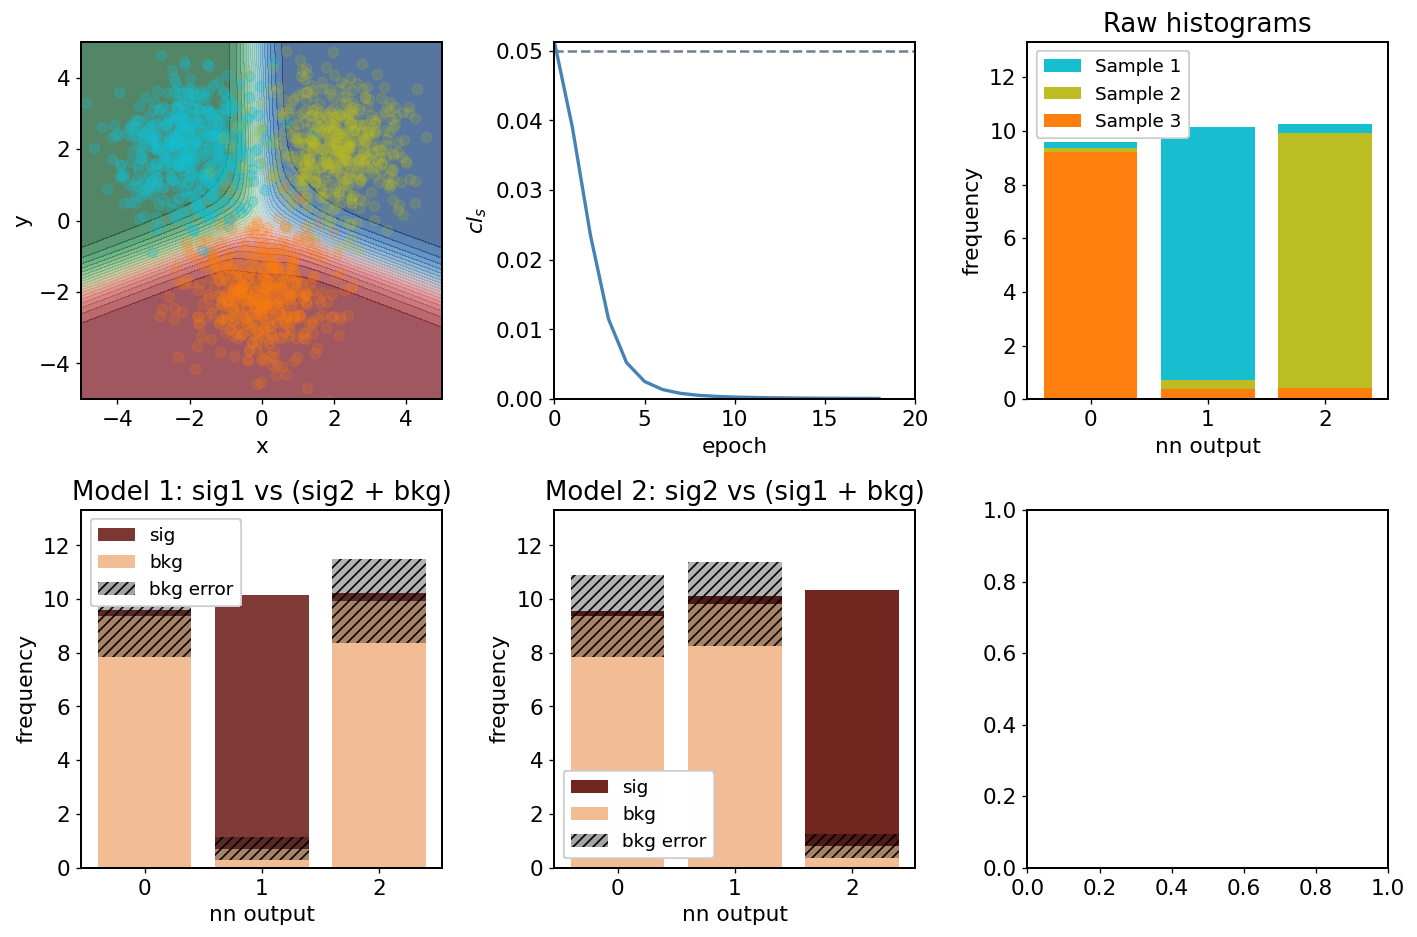

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from celluloid import Camera
from IPython.display import HTML

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [12.0, 8.0],
        "font.size": 13,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "legend.fontsize": 11,
    }
)

fig, axarr = plt.subplots(2, 3, dpi=120)
axarr = axarr.flatten()
# fig.set_size_inches(15, 10)
camera = Camera(fig)

maxN = 20 # make me bigger for better results!

animate = True # animations fail tests

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axarr, network, metrics, nnm.hm, nnm2.hm, maxN=maxN, ith=i)
        plt.tight_layout()
        camera.snap()
if animate:
    camera.animate().save("animation.gif", writer="imagemagick", fps=10)